[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Showmick119/Benchmarking-Signal-Processing-Packages/blob/main/test/test_hrv_model.ipynb)

# **XGBoost Peak Classification - Model Testing**
---
- **Repository: [Benchmarking-Signal-Processing-Packages](https://github.com/Showmick119/Benchmarking-Signal-Processing-Packages)**
- **Author: Showmick Das**
- **Purpose: Testing a pre-trained XGBoost model for peak classification on unseen PPG datasets**  
- **Created: June 2025**  
---


This notebook loads a pre-trained XGBoost classifier and tests it on **one selected dataset** at a time from 470 available unseen PPG datasets.

**Purpose**: An interface to showcase our peak classification work

**Steps:**
1. Setup environment (Auto-detects Local vs Google Colab)
2. Load pre-trained model from `test/` directory
3. Discover and select **ONE dataset** from all available data (470 total)
4. Process selected dataset (extract features)
5. Run inference and visualize results
6. Compare initial vs corrected vs ground truth SDNN

**Testing Workflow**: 
- **One dataset per run** - focused, reproducible analysis
- Change `DATASET_NUMBER` and re-run cells 8-20 to test different datasets
- No need to restart notebook - model stays loaded

**Required Files**: This notebook needs these trained model files in the `test/` directory:
- `trained_xgboost_model.pkl` (trained XGBoost model)
- `feature_scaler.pkl` (trained feature scaler)

**If Coming from Colab**: 
- These files are auto-downloaded from the training notebook
- Manually place them in your repository's `test/` directory before running this notebook

## **Setup**

In [ ]:
# FOR GOOGLE COLAB (uncomment when in Colab Environment):
!git clone https://github.com/Showmick119/Benchmarking-Signal-Processing-Packages.git
%cd Benchmarking-Signal-Processing-Packages/
!pip install xgboost scikit-learn matplotlib seaborn pandas numpy scipy
!pip install EMD-signal
!pip install wfdb
from google.colab import files

# FOR LOCAL TESTING (uncomment when in Local Environment):
# import os
# print(f"Current working directory: {os.getcwd()}")
# print("Running in local development mode")
# print("Make sure you have all required packages installed:")
# print("  - xgboost, scikit-learn, matplotlib, seaborn, pandas, numpy, scipy")

# Environment Detection
try:
    import google.colab
    IN_COLAB = True
    print("Google Colab environment detected")
except ImportError:
    IN_COLAB = False
    print("Local environment detected")

Current working directory: c:\Users\showm\OneDrive\Desktop\Benchmarking-Signal-Processing-Packages\test
Running in local development mode
Make sure you have all required packages installed:
  - xgboost, scikit-learn, matplotlib, seaborn, pandas, numpy, scipy
Local environment detected


## **Load Pre-trained Model**

In [2]:
import os
import sys
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import find_peaks, peak_prominences, peak_widths
import pywt

current_dir = os.getcwd()
if 'test' in os.path.basename(current_dir):
    project_root = os.path.dirname(current_dir)
    if project_root not in sys.path:
        sys.path.append(project_root)
    print("Local environment detected (running from test/ directory)")
else:
    project_root = current_dir
    print("Colab environment detected (running from project root)")

from models.XGBoostClassifier import XGBoostPeakClassifier

print("Dependencies imported successfully!")
print(f"Current working directory: {current_dir}")
print(f"Project root: {project_root}")

Local environment detected (running from test/ directory)
Dependencies imported successfully!
Current working directory: c:\Users\showm\OneDrive\Desktop\Benchmarking-Signal-Processing-Packages\test
Project root: c:\Users\showm\OneDrive\Desktop\Benchmarking-Signal-Processing-Packages


In [3]:
if 'test' in os.path.basename(os.getcwd()):
    model_path = 'trained_xgboost_model.pkl'
    scaler_path = 'feature_scaler.pkl'
    print("Local mode: Looking for model files in current directory")
else:
    model_path = 'test/trained_xgboost_model.pkl'
    scaler_path = 'test/feature_scaler.pkl'
    print("Colab mode: Looking for model files in test/ subdirectory")

print(f"Expected model path: {model_path}")
print(f"Expected scaler path: {scaler_path}")

try:
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    print("Pre-trained model loaded successfully!")
    print("Feature scaler loaded successfully!")
    print("Ready for inference on unseen datasets!")
except FileNotFoundError as e:
    print("MODEL FILES NOT FOUND!")
    print("\nTo fix this issue:")
    if IN_COLAB:
        print("1. You're in Colab - model files should be downloaded from training notebook")
        print("2. Make sure you manually placed these files in your repository:")
        print("   - trained_xgboost_model.pkl → /test/trained_xgboost_model.pkl")
        print("   - feature_scaler.pkl → /test/feature_scaler.pkl")
        print("3. Commit and push the files to your repository")
        print("4. Re-clone the repository in Colab to get the files")
    else:
        print("1. You're running locally")
        print("2. Run the training notebook (train_hrv_model.ipynb) first")
        print("3. The training notebook will generate these required files")
        print("4. Then come back and run this testing notebook")
    
    print(f"\n Currently looking for:")
    print(f"   - {model_path}")
    print(f"   - {scaler_path}")
    print("\nCannot proceed without trained model files!")
    raise

Local mode: Looking for model files in current directory
Expected model path: trained_xgboost_model.pkl
Expected scaler path: feature_scaler.pkl
Pre-trained model loaded successfully!
Feature scaler loaded successfully!
Ready for inference on unseen datasets!


c:\Users\showm\AppData\Local\Programs\Python\Python312\Lib\pickle.py:1760: UserWarning: [12:24:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
c:\Users\showm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainabilit

## **Dataset Discovery & Selection**

In [4]:
def find_all_datasets():
    """Scan all 4 data subdirectories for available datasets"""
    if 'test' in os.path.basename(os.getcwd()):
        data_prefix = '../data/'
    else:
        data_prefix = 'data/'
    
    base_dirs = [
        f'{data_prefix}HR_Lab_Data_Day_1_Mom/',
        f'{data_prefix}HR_Lab_Data_Day_1_Teen/', 
        f'{data_prefix}HR_Lab_Data_Day_2_Mom/',
        f'{data_prefix}HR_Lab_Data_Day_2_Teen/'
    ]
    
    all_datasets = []
    for base_dir in base_dirs:
        if os.path.exists(base_dir):
            datasets = [d for d in os.listdir(base_dir) 
                       if os.path.isdir(os.path.join(base_dir, d)) and 'HRV' in d]
            for dataset in datasets:
                dataset_path = os.path.join(base_dir, dataset)
                if os.path.exists(os.path.join(dataset_path, 'bangle.csv')):
                    all_datasets.append(dataset_path)
    
    return sorted(all_datasets)

datasets = find_all_datasets()
print(f"Found {len(datasets)} available datasets with PPG data:")
print("="*60)
for i, dataset in enumerate(datasets):
    print(f"{i+1:3d}. {dataset}")

Found 470 available datasets with PPG data:
  1. ../data/HR_Lab_Data_Day_1_Mom/HRV102M_Finger_Anticipatory
  2. ../data/HR_Lab_Data_Day_1_Mom/HRV102M_Finger_Baseline
  3. ../data/HR_Lab_Data_Day_1_Mom/HRV102M_Finger_Mental_Stress
  4. ../data/HR_Lab_Data_Day_1_Mom/HRV102M_Finger_Physical_Stress
  5. ../data/HR_Lab_Data_Day_1_Mom/HRV102M_Finger_Relaxed
  6. ../data/HR_Lab_Data_Day_1_Mom/HRV103M_Finger_Anticipatory
  7. ../data/HR_Lab_Data_Day_1_Mom/HRV103M_Finger_Baseline
  8. ../data/HR_Lab_Data_Day_1_Mom/HRV103M_Finger_Mental_Stress
  9. ../data/HR_Lab_Data_Day_1_Mom/HRV103M_Finger_Physical_Stress
 10. ../data/HR_Lab_Data_Day_1_Mom/HRV103M_Finger_Relaxed
 11. ../data/HR_Lab_Data_Day_1_Mom/HRV104M_Finger_Anticipatory
 12. ../data/HR_Lab_Data_Day_1_Mom/HRV104M_Finger_Baseline
 13. ../data/HR_Lab_Data_Day_1_Mom/HRV104M_Finger_Mental_Stress
 14. ../data/HR_Lab_Data_Day_1_Mom/HRV104M_Finger_Physical_Stress
 15. ../data/HR_Lab_Data_Day_1_Mom/HRV104M_Finger_Relaxed
 16. ../data/HR_Lab_Data_D

## **Enter a Number between 1-470 to get a Dataset for Analysis**
- Refer to the output of the cell above, to see which number refers to which Dataset

In [5]:
print("\nEnter the number of the dataset you want to analyze:")
selected_idx = int(input()) - 1

if 0 <= selected_idx < len(datasets):
    selected_dataset = datasets[selected_idx]
    dataset_name = os.path.basename(selected_dataset)
    print(f"\n✓ Selected: {selected_dataset}")
    print(f"✓ Dataset name: {dataset_name}")
else:
    print("Invalid selection!")


Enter the number of the dataset you want to analyze:

✓ Selected: ../data/HR_Lab_Data_Day_1_Teen/HRV132T_Finger_Physical_Stress
✓ Dataset name: HRV132T_Finger_Physical_Stress


## **Process Selected Dataset**

In [6]:
def process_unseen_dataset(dataset_path):
    """
    Process a single dataset to extract features for prediction.
    This extracts core logic from prepare_data.py for processing one dataset.
    
    Returns:
        features_matrix: numpy array of shape (n_peaks, 15) 
        peak_times: array of peak timestamps
        peak_indices: array of peak indices in signal
        ppg_signal: filtered PPG signal
        time_ppg: time array for PPG
    """
    from utils import LoadDataset, Filters
    from scipy.signal import find_peaks, peak_widths, peak_prominences
    from scipy.integrate import trapezoid
    
    print(f"Processing dataset: {dataset_path}")
    
    data_loader = LoadDataset(dataset_path)
    time_ecg, ecg, time_ppg, ppg, time_polarHRM, polarHRM = data_loader.get_data()
    
    filter_obj = Filters()
    filtered_ppg = filter_obj.cheby2_filter(time_ppg, ppg, order=4, rs=40, signal_type='PPG', plot=False)
    
    peak_indices, _ = find_peaks(filtered_ppg, height=np.mean(filtered_ppg))
    peak_times = time_ppg[peak_indices]
    
    print(f"Detected {len(peak_indices)} initial peaks")
    
    def calculate_features_for_peak(peak_idx, all_peak_indices, signal, time):
        """Calculate 15 features for a peak (simplified version from prepare_data.py)"""
        features = []
        
        try:
            # 1. Amplitude
            amplitude = signal[peak_idx] if 0 <= peak_idx < len(signal) else 0
            features.append(amplitude)

            # 2. Prominence
            try:
                valid_peaks = all_peak_indices[(all_peak_indices >= 0) & (all_peak_indices < len(signal))]
                if len(valid_peaks) > 0 and peak_idx in valid_peaks:
                    prominences = peak_prominences(signal, valid_peaks)[0]
                    prominence_idx = list(valid_peaks).index(peak_idx)
                    prominence_val = prominences[prominence_idx]
                else:
                    prominence_val = 0
            except:
                prominence_val = 0
            features.append(prominence_val)

            # 3. Width at Half Prominence
            try:
                valid_peaks = all_peak_indices[(all_peak_indices >= 0) & (all_peak_indices < len(signal))]
                if len(valid_peaks) > 0 and peak_idx in valid_peaks:
                    widths = peak_widths(signal, valid_peaks, rel_height=0.50)[0]
                    width_idx = list(valid_peaks).index(peak_idx)
                    width_half_prom = widths[width_idx]
                else:
                    width_half_prom = 0
            except:
                width_half_prom = 0
            features.append(width_half_prom)

            # 4. Pulse Area
            try:
                window = min(20, len(signal) // 10, peak_idx, len(signal) - peak_idx - 1)
                window = max(1, window)
                start_idx = max(0, peak_idx - window)
                end_idx = min(len(signal), peak_idx + window + 1)
                
                if start_idx < end_idx:
                    segment = signal[start_idx:end_idx]
                    baseline = np.min(segment)
                    adjusted = segment - baseline
                    adjusted = np.maximum(adjusted, 0)
                    pulse_area = trapezoid(adjusted, dx=1)
                else:
                    pulse_area = 0
            except:
                pulse_area = 0
            features.append(pulse_area)

            # 5-6. Rise and Decay Times
            try:
                window = min(20, len(signal) // 10, peak_idx, len(signal) - peak_idx - 1)
                window = max(1, window)
                start_idx = max(0, peak_idx - window)
                end_idx = min(len(signal), peak_idx + window + 1)

                # Rise Time
                if start_idx < peak_idx:
                    before_segment = signal[start_idx:peak_idx]
                    min_before_idx = np.argmin(before_segment) + start_idx
                    rise_time = abs(time[peak_idx] - time[min_before_idx])
                else:
                    rise_time = 0

                # Decay Time
                if peak_idx < end_idx - 1:
                    after_segment = signal[peak_idx:end_idx]
                    min_after_idx = np.argmin(after_segment) + peak_idx
                    decay_time = abs(time[min_after_idx] - time[peak_idx])
                else:
                    decay_time = 0
            except:
                rise_time = decay_time = 0
            features.extend([rise_time, decay_time])

            # 7-8. Max upslope and max inflection
            try:
                window = min(10, len(signal) // 20, peak_idx, len(signal) - peak_idx - 1)
                window = max(1, window)
                start_idx = max(0, peak_idx - window)
                end_idx = min(len(signal), peak_idx + window + 1)

                # Max Upslope
                if peak_idx > 0 and start_idx < peak_idx:
                    rising_segment = signal[start_idx:(peak_idx + 1)]
                    if len(rising_segment) > 1:
                        rising_deriv1 = np.diff(rising_segment, n=1)
                        max_upslope = np.max(rising_deriv1) if len(rising_deriv1) > 0 else 0
                    else:
                        max_upslope = 0
                else:
                    max_upslope = 0
                
                # Max Inflection
                if start_idx < end_idx:
                    segment = signal[start_idx:end_idx]
                    if len(segment) > 2:
                        segment_deriv2 = np.diff(segment, n=2)
                        max_inflection = np.max(np.abs(segment_deriv2)) if len(segment_deriv2) > 0 else 0
                    else:
                        max_inflection = 0
                else:
                    max_inflection = 0
            except:
                max_upslope = max_inflection = 0
            features.extend([max_upslope, max_inflection])

            # 9-11. Inter-Beat Intervals
            try:
                valid_peaks = all_peak_indices[(all_peak_indices >= 0) & (all_peak_indices < len(signal))]
                valid_peaks = np.sort(valid_peaks)
                
                peak_position = np.where(valid_peaks == peak_idx)[0]
                if len(peak_position) > 0:
                    pos = peak_position[0]

                    # Previous IBI
                    if pos > 0:
                        prev_peak_idx = valid_peaks[pos - 1]
                        ibi_prev = abs(time[peak_idx] - time[prev_peak_idx])
                    else:
                        ibi_prev = 0

                    # Next IBI
                    if (pos + 1) < len(valid_peaks):
                        next_peak_idx = valid_peaks[pos + 1]
                        ibi_next = abs(time[next_peak_idx] - time[peak_idx])
                    else:
                        ibi_next = 0

                    # IBI Ratio
                    ibi_ratio = ibi_next / ibi_prev if ibi_prev > 0 and ibi_next > 0 else 0
                else:
                    ibi_prev = ibi_next = ibi_ratio = 0
            except:
                ibi_prev = ibi_next = ibi_ratio = 0
            features.extend([ibi_prev, ibi_next, ibi_ratio])

            # 12-13. Signal Quality Metrics
            try:
                window = min(20, len(signal) // 10, peak_idx, len(signal) - peak_idx - 1)
                window = max(1, window)
                start_idx = max(0, peak_idx - window)
                end_idx = min(len(signal), peak_idx + window + 1)
                
                if start_idx < end_idx:
                    segment = signal[start_idx:end_idx]
                    # Local Variance
                    local_variance = np.var(segment)
                    # SNR
                    signal_power = np.mean(segment ** 2)
                    if signal_power > 0 and local_variance > 0:
                        noise_power = local_variance ** 2
                        snr = 10 * np.log10(signal_power / noise_power) if noise_power > 0 else 0
                    else:
                        snr = 0
                else:
                    local_variance = snr = 0
            except:
                local_variance = snr = 0
            features.extend([local_variance, snr])

            # 14-15. Frequency Features
            try:
                window = min(50, len(signal) // 5, peak_idx, len(signal) - peak_idx - 1)
                window = max(4, window)
                start_idx = max(0, peak_idx - window)
                end_idx = min(len(signal), peak_idx + window + 1)
                
                if start_idx < end_idx:
                    segment = signal[start_idx:end_idx]
                    if len(segment) >= 4:
                        # Frequency Energy using FFT
                        try:
                            fft = np.fft.fft(segment)
                            freq_energy = np.sum(np.abs(fft) ** 2)
                        except:
                            freq_energy = 0

                        # Wavelet Coefficient
                        try:
                            coeffs = pywt.wavedec(segment, 'db4', level=1)
                            if len(coeffs) > 1 and len(coeffs[1]) > 0:
                                detail_coef = coeffs[1]
                                wavelet_coef = np.mean(np.abs(detail_coef))
                            else:
                                wavelet_coef = 0
                        except:
                            wavelet_coef = 0
                    else:
                        freq_energy = wavelet_coef = 0
                else:
                    freq_energy = wavelet_coef = 0
            except:
                freq_energy = wavelet_coef = 0
            features.extend([freq_energy, wavelet_coef])

            for i, feature in enumerate(features):
                if not np.isfinite(feature):
                    features[i] = 0
                    
            if len(features) != 15:
                features = (features + [0] * 15)[:15]

        except Exception as e:
            print(f"Error calculating features for peak at {peak_idx}: {e}")
            features = [0] * 15

        return features
    
    features_matrix = []
    for peak_idx in peak_indices:
        features = calculate_features_for_peak(peak_idx, peak_indices, filtered_ppg, time_ppg)
        features_matrix.append(features)
    
    features_matrix = np.array(features_matrix)
    
    print(f"Calculated features matrix shape: {features_matrix.shape}")
    
    return features_matrix, peak_times, peak_indices, filtered_ppg, time_ppg

features, peak_times, peak_indices, ppg_signal, time_ppg = process_unseen_dataset(selected_dataset)

print(f"\nDataset processed successfully!")
print(f"Features shape: {features.shape}")
print(f"Number of detected peaks: {len(peak_indices)}")

Processing dataset: ../data/HR_Lab_Data_Day_1_Teen/HRV132T_Finger_Physical_Stress
Signal Frequency = 50.000 Hz

Detected 273 initial peaks
Calculated features matrix shape: (273, 15)

Dataset processed successfully!
Features shape: (273, 15)
Number of detected peaks: 273


c:\Users\showm\AppData\Local\Programs\Python\Python312\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 1 is too high: all coefficients will experience boundary effects.
  warnings.warn(


## **Initial Visualization & SDNN**

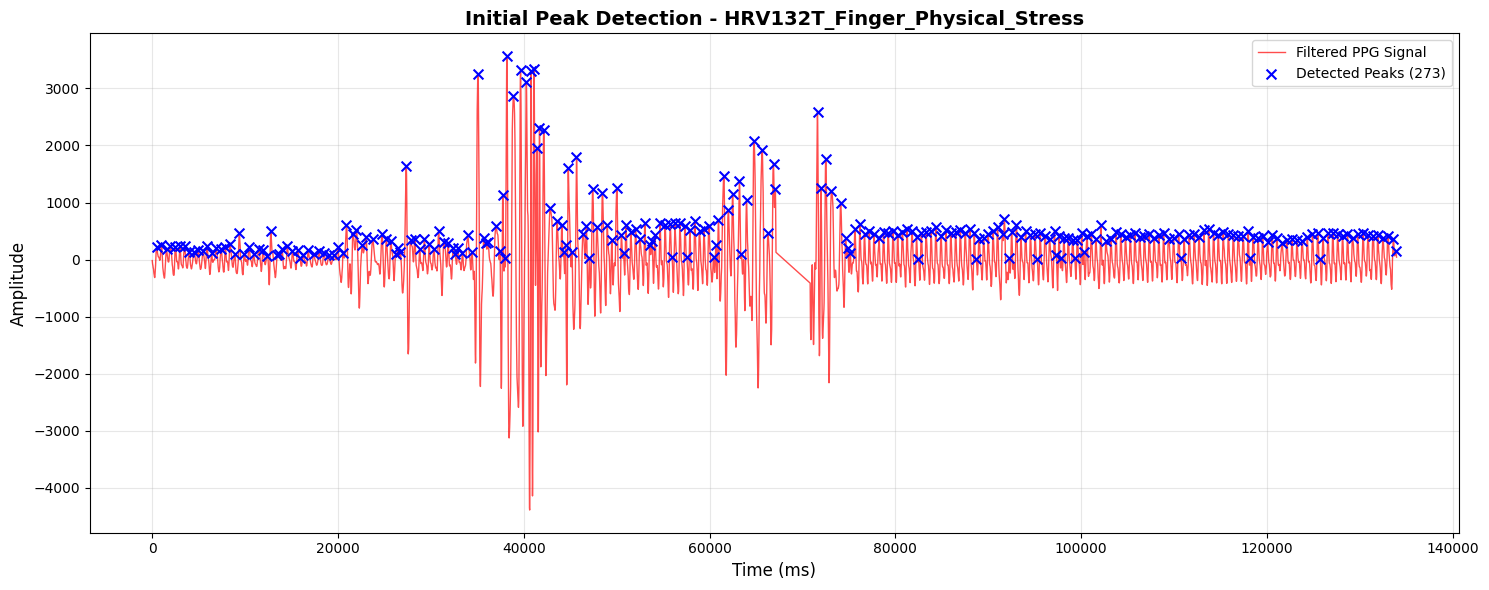

Initial SDNN (all detected peaks): 283.048 ms
Total peaks detected: 273


In [7]:
plt.figure(figsize=(15, 6))
plt.plot(time_ppg, ppg_signal, label='Filtered PPG Signal', alpha=0.7, color='red', linewidth=1)
plt.scatter(peak_times, ppg_signal[peak_indices], color='blue', s=50, marker='x', 
           label=f'Detected Peaks ({len(peak_indices)})', zorder=5)
plt.title(f'Initial Peak Detection - {dataset_name}', fontsize=14, fontweight='bold')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

initial_sdnn = XGBoostPeakClassifier.calculate_sdnn(peak_times)
print(f"Initial SDNN (all detected peaks): {initial_sdnn:.3f} ms")
print(f"Total peaks detected: {len(peak_indices)}")

## **Model Prediction**

In [8]:
print("Running model inference...")
features_scaled = scaler.transform(features)
predicted_labels = model.predict(features_scaled)

true_peak_mask = predicted_labels == 1
false_peak_mask = predicted_labels == 0

true_peak_indices = peak_indices[true_peak_mask]
false_peak_indices = peak_indices[false_peak_mask]
true_peak_times = peak_times[true_peak_mask]
false_peak_times = peak_times[false_peak_mask]

print(f"Model predictions:")
print(f"  True peaks (kept): {np.sum(true_peak_mask)}")
print(f"  False peaks (removed): {np.sum(false_peak_mask)}")
print(f"  Removal rate: {np.sum(false_peak_mask)/len(predicted_labels)*100:.1f}%")

Running model inference...
Model predictions:
  True peaks (kept): 230
  False peaks (removed): 43
  Removal rate: 15.8%


## **Corrected Visualization**

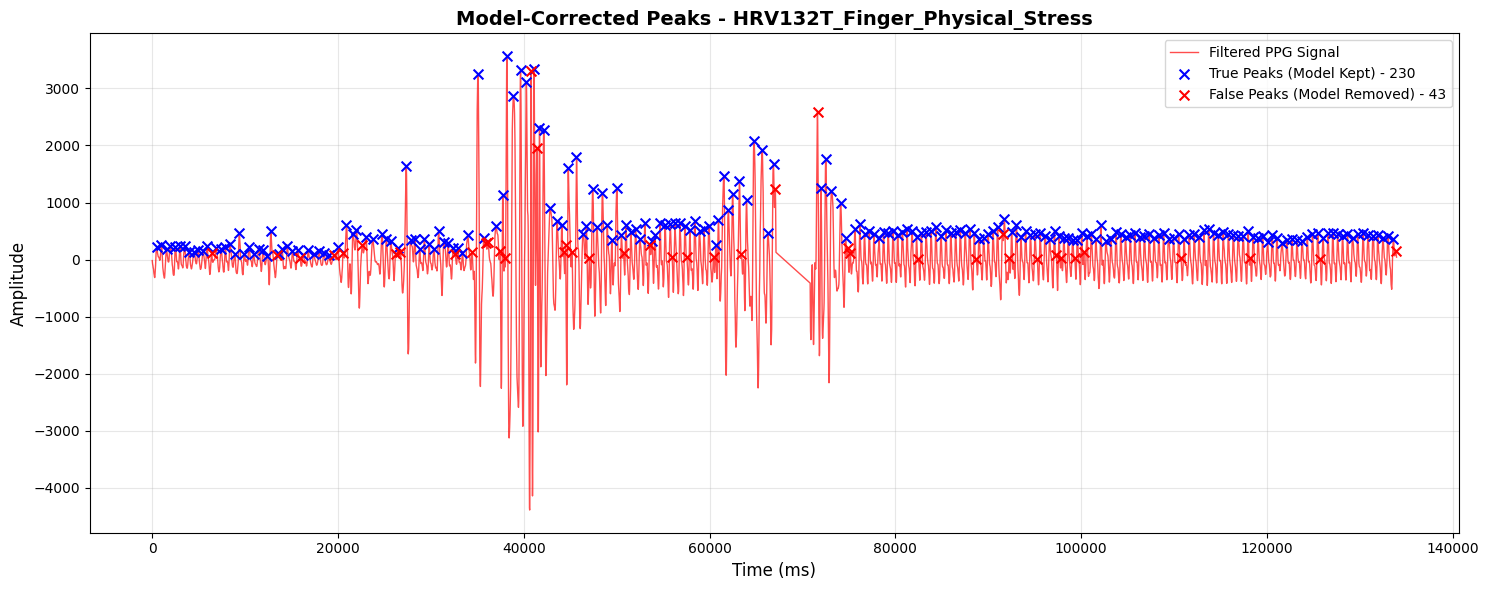

Corrected SDNN (model filtered): 87.328 ms
SDNN change: -195.721 ms


In [9]:
plt.figure(figsize=(15, 6))
plt.plot(time_ppg, ppg_signal, label='Filtered PPG Signal', alpha=0.7, color='red', linewidth=1)

if len(true_peak_indices) > 0:
    plt.scatter(true_peak_times, ppg_signal[true_peak_indices], 
               color='blue', s=50, marker='x', label=f'True Peaks (Model Kept) - {len(true_peak_indices)}', zorder=5)

if len(false_peak_indices) > 0:
    plt.scatter(false_peak_times, ppg_signal[false_peak_indices], 
               color='red', s=50, marker='x', label=f'False Peaks (Model Removed) - {len(false_peak_indices)}', zorder=5)

plt.title(f'Model-Corrected Peaks - {dataset_name}', fontsize=14, fontweight='bold')
plt.xlabel('Time (ms)', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

corrected_sdnn = XGBoostPeakClassifier.calculate_sdnn_corrected(peak_times, predicted_labels)
print(f"Corrected SDNN (model filtered): {corrected_sdnn:.3f} ms")
print(f"SDNN change: {corrected_sdnn - initial_sdnn:+.3f} ms")

## **Ground Truth Comparison**

In [10]:
print("Calculating ground truth SDNN from ECG data...")
ground_truth_sdnn = XGBoostPeakClassifier.calculate_ecg_sdnn(dataset_name)

if ground_truth_sdnn is not None:
    print(f"Ground Truth SDNN (ECG): {ground_truth_sdnn:.3f} ms")

    initial_error = abs(initial_sdnn - ground_truth_sdnn)
    corrected_error = abs(corrected_sdnn - ground_truth_sdnn)
    improvement = initial_error - corrected_error
    
    print(f"\nError Analysis:")
    print(f"  Initial error:     {initial_error:.3f} ms ({100*initial_error/ground_truth_sdnn:.1f}%)")
    print(f"  Corrected error:   {corrected_error:.3f} ms ({100*corrected_error/ground_truth_sdnn:.1f}%)")
    print(f"  Improvement:       {improvement:+.3f} ms ({'✓ Better' if improvement > 0 else '✗ Worse'})")
else:
    print(" Ground truth ECG data not available for this dataset")
    ground_truth_sdnn = None

Calculating ground truth SDNN from ECG data...
Signal Frequency = 130.001 Hz

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.
Calculated ECG SDNN for HRV132T_Finger_Physical_Stress: 19.255 ms (257 peaks)
Ground Truth SDNN (ECG): 19.255 ms

Error Analysis:
  Initial error:     263.793 ms (1370.0%)
  Corrected error:   68.072 ms (353.5%)
  Improvement:       +195.721 ms (✓ Better)


## **SDNN Comparison Visualization**

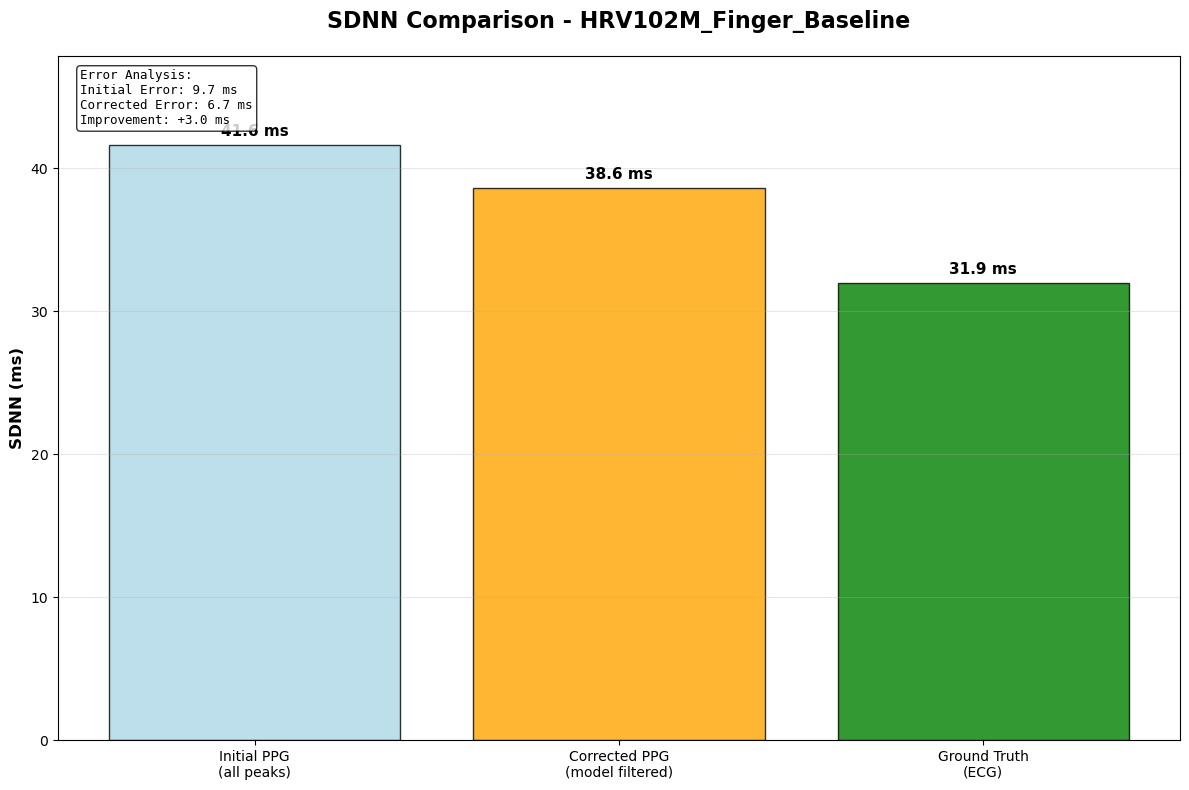


FINAL RESULTS SUMMARY
Dataset: HRV102M_Finger_Baseline
Initial PPG SDNN:    41.607 ms (143 peaks)
Corrected PPG SDNN:  38.607 ms (142 peaks)
Ground Truth SDNN:   31.946 ms (ECG)
Model improved accuracy by: +3.000 ms
Model removed 1 false peaks (0.7%)


In [ ]:
plt.figure(figsize=(12, 8))

methods = ['Initial PPG\n(all peaks)', 'Corrected PPG\n(model filtered)']
sdnn_values = [initial_sdnn, corrected_sdnn]
colors = ['lightblue', 'orange']

if ground_truth_sdnn is not None:
    methods.append('Ground Truth\n(ECG)')
    sdnn_values.append(ground_truth_sdnn)
    colors.append('green')

bars = plt.bar(methods, sdnn_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

for bar, value in zip(bars, sdnn_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + max(sdnn_values)*0.01, 
             f'{value:.1f} ms', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title(f'SDNN Comparison - {dataset_name}', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('SDNN (ms)', fontsize=12, fontweight='bold')
plt.ylim(0, max(sdnn_values) * 1.15)

plt.grid(True, alpha=0.3, axis='y')

if ground_truth_sdnn is not None:
    stats_text = f"""Error Analysis:
Initial Error: {abs(initial_sdnn - ground_truth_sdnn):.1f} ms
Corrected Error: {abs(corrected_sdnn - ground_truth_sdnn):.1f} ms
Improvement: {(abs(initial_sdnn - ground_truth_sdnn) - abs(corrected_sdnn - ground_truth_sdnn)):+.1f} ms"""
    
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
             verticalalignment='top', fontfamily='monospace', fontsize=9)

plt.tight_layout()
plt.show()

print(f"\n" + "="*60)
print(f"FINAL RESULTS SUMMARY")
print(f"="*60)
print(f"Dataset: {dataset_name}")
print(f"Initial PPG SDNN:    {initial_sdnn:.3f} ms ({len(peak_indices)} peaks)")
print(f"Corrected PPG SDNN:  {corrected_sdnn:.3f} ms ({len(true_peak_indices)} peaks)")
if ground_truth_sdnn is not None:
    print(f"Ground Truth SDNN:   {ground_truth_sdnn:.3f} ms (ECG)")
    print(f"Model improved accuracy by: {(abs(initial_sdnn - ground_truth_sdnn) - abs(corrected_sdnn - ground_truth_sdnn)):+.3f} ms")
else:
    print(f"Ground Truth SDNN:   Not available")
print(f"Model removed {len(false_peak_indices)} false peaks ({len(false_peak_indices)/len(peak_indices)*100:.1f}%)")
print(f"="*60)

## **If You Want To Test Another Dataset**
1. **Change the `DATASET_NUMBER`** in the selection cell (Cell 8) 
2. **Re-run cells 8-20** to analyze the new dataset
3. **The model and scaler are already loaded** - no need to restart!

**Suggestions:**
- Try different participants: **Mom vs Teen**
- Compare conditions: **Baseline vs Stress vs Relaxed**
- Test across different days: **Day 1 vs Day 2**
- **Popular datasets to try:**
  - Dataset #1: `HRV102M_Finger_Anticipatory` (Mother, Day 1)
  - Dataset #121: `HRV102T_Finger_Anticipatory` (Teen, Day 1) 
  - Dataset #241: `HRV102M_Finger_Anticipatory` (Mother, Day 2)
  - Dataset #356: `HRV102T_Finger_Anticipatory` (Teen, Day 2)

**Each run tests exactly ONE dataset** - this notebook is designed for focused, reproducible single-dataset analysis.

## **Results Interpretation Guide**

**What This Analysis Shows:**
- **Initial PPG SDNN**: Raw peak detection without ML filtering (usually overestimated)
- **Corrected PPG SDNN**: After ML model removes false peaks (more accurate)
- **Ground Truth SDNN**: ECG-based reference (when available)

**Good Results Indicators:**
- Model removes false peaks (10-30% removal rate is typical)
- Corrected SDNN closer to Ground Truth than Initial SDNN
- Positive improvement value in error analysis

**Typical Patterns:**
- **Baseline condition**: Lower SDNN (more regular heart rhythm)
- **Stress conditions**: Variable SDNN depending on individual response
- **Relaxed condition**: Often higher SDNN (more heart rate variability)

**For Research/Analysis:**
- Compare same participant across different conditions
- Look at Mom vs Teen differences for same conditions
- Day 1 vs Day 2 comparisons to see consistency